# MovieLens Recommender System


This notebook is divided into the following parts:

1. Data Cleaning
2. Data Analysis
3. Collaborative Filtering Recommender System


Install required libraries.


In [1]:
%pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import libraries.


In [2]:
from wordcloud import WordCloud
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import f1_score, mean_squared_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd


Import all the datasets except for the `link` dataset.


In [3]:
movies_df = pd.read_csv("ml-latest/movies.csv")
movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv("ml-latest/ratings.csv")
ratings_df.head()


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [5]:
tags_df = pd.read_csv("ml-latest/tags.csv")
tags_df.head()


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


## Part 1: Data Cleaning


Check for 'null' values in the dataset.


In [6]:
movies_df.isnull().any()


movieId    False
title      False
genres     False
dtype: bool

In [7]:
ratings_df.isnull().any()


userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [8]:
tags_df.isnull().any()


userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

Drop 'null' values from the dataset.


In [9]:
movies_df = movies_df.dropna()
ratings_df = ratings_df.dropna()
tags_df = tags_df.dropna()


Extract year from "title" for analysis.


In [10]:
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)", expand=False)
movies_df


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,2011
58095,193880,Her Name Was Mumu (2016),Drama,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,2017


In [11]:
movies_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
 3   year     57771 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


There is some discrepancy in the "year" column with respect to the whole dataset.


In [12]:
movies_df[movies_df["year"].isnull()]


,movieId,title,genres,year
10023,32930,Category 6: Day of Destruction,Action|Drama,NaN
10613,40697,Babylon 5,Sci-Fi,NaN
15719,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,NaN
17444,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,NaN
22651,107434,Diplomatic Immunity (2009– ),Comedy,NaN
...,...,...,...,...
57504,192339,The Sign of Three,(no genres listed),NaN
57674,192829,Parwaaz Hai Junoon,Adventure|Children|Romance,NaN
57789,193149,¿Qué te juegas?,(no genres listed),NaN
57903,193443,Wall,(no genres listed),NaN


The analysis has revealed two key insights:

1. Certain movies lack a specific year of release.
2. Certain movies do not have a designated genre.

To improve the dataset's robustness, movies that lack information about their genre or release year will be removed.


In [13]:
movies_df = movies_df[movies_df["genres"] != "(no genres listed)"]
movies_df = movies_df.dropna()
movies_df["year"] = movies_df["year"].astype(int)
movies_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53717 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  53717 non-null  int64 
 1   title    53717 non-null  object
 2   genres   53717 non-null  object
 3   year     53717 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


Parse the genres.


In [14]:
# Create new columns for each genre and set binary values
# Step 1: Extract all unique genres from the "genres" column
# Step 2: Create a new column for each unique genre
# Step 3: Assign a binary value of 1 if the movie belongs to that genre and 0 otherwise
# Step 4: Drop the original "genres" column
movies_df = movies_df.join(movies_df["genres"].str.get_dummies("|"))
movies_df.drop("genres", axis=1, inplace=True)
movies_df.head()


,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Is it possible to remove some of the less useful genres? An analysis of genre-ratings would be necessary figure that out.


In [15]:
genre_freqs = movies_df.iloc[:, 3:].sum()
genre_freqs


Action          7114
Adventure       4058
Animation       2661
Children        2744
Comedy         15938
Crime           5099
Documentary     5082
Drama          24105
Fantasy         2632
Film-Noir        364
Horror          5543
IMAX             197
Musical         1112
Mystery         2770
Romance         7407
Sci-Fi          3434
Thriller        8199
War             1820
Western         1378
dtype: int64

The ratings DataFrame will now be merged with the tags DataFrame to facilitate rating and tag analysis. However, prior to that, the timestamp columns will be dropped since they do not appear to be useful for the analysis.


In [16]:
ratings_df = ratings_df.drop("timestamp", axis=1)
tags_df = tags_df.drop("timestamp", axis=1)
ratings_and_tags_df = pd.merge(ratings_df, tags_df, on=["userId", "movieId"])
ratings_and_tags_df.head(10)


,userId,movieId,rating,tag
0,14,110,4.5,epic
1,14,110,4.5,Medieval
2,14,318,4.5,imdb top 250
3,14,318,4.5,justice
4,14,480,4.5,Dinosaurs
5,14,593,4.5,psychothriller
6,14,1682,4.0,philosophy
7,14,1682,4.0,surveillance
8,14,7458,4.0,Epic
9,14,95311,4.5,Pixar


It may be necessary to merge movies and ratings to identify any relationships between genres and ratings.


In [17]:
# Merge the movies_df and ratings_df DataFrames based on movieId; this creates a cross product of the two DataFrames
# Duplicate rows will be removed, and only the mean value of ratings for each movie will be kept
movies_and_ratings_df = pd.merge(movies_df, ratings_df, on=["movieId"])
columns_to_remove = ["userId", "rating"]
columns_to_keep = [
    col for col in movies_and_ratings_df.columns if col not in columns_to_remove
]
# Calculate the mean ratings of each movie
movies_and_ratings_df = (
    movies_and_ratings_df.groupby(columns_to_keep)["rating"].mean().reset_index()
)
movies_and_ratings_df.rename(columns={"rating": "mean_rating"}, inplace=True)
movies_and_ratings_df.head(20)


,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,mean_rating
0,1,Toy Story (1995),1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.886649
1,2,Jumanji (1995),1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.246583
2,3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.173981
3,4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2.874540
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.077291
5,6,Heat (1995),1995,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,3.844211
6,7,Sabrina (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.371348
7,8,Tom and Huck (1995),1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.122482
8,9,Sudden Death (1995),1995,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.007530
9,10,GoldenEye (1995),1995,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.431633


In [18]:
# Tags + Movies dataset
tags_and_movies_df = pd.merge(tags_df, movies_df, on=["movieId"], how="inner")
tags_and_movies_df


,userId,movieId,tag,title,year,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,14,110,epic,Braveheart (1995),1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,14,110,Medieval,Braveheart (1995),1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,815,110,overrated,Braveheart (1995),1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2577,110,Oscar (Best Picture),Braveheart (1995),1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3086,110,epic,Braveheart (1995),1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099903,282119,164453,engineer,Failure of Engineer Garin (1973),1973,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1099904,282119,164453,soviet classics,Failure of Engineer Garin (1973),1973,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1099905,283000,91960,Amazingly Bad,"Magic Christmas Tree, The (1964)",1964,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1099906,283000,91960,Effeminate Tree,"Magic Christmas Tree, The (1964)",1964,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Rating + Tags + Movies dataset
combined_df = pd.merge(ratings_and_tags_df, movies_df, on=["movieId"], how="inner")
combined_df.columns.values


array(['userId', 'movieId', 'rating', 'tag', 'title', 'year', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

## Part 2: Data Analysis


This section aims to address several questions that can help in constructing a recommender system:

1. How is the genre of a movie related to its rating?
2. How is the year of release of a movie related to its rating?
3. How is the presence of tags related to the rating of a movie?
4. How is the combination of tags and genres related to the rating of a movie?
5. Are there any sparsely occurring genres that can be eliminated to enhance the efficiency of the system?
6. Which of the aforementioned features are significant for our recommendation system?


### Relationship between Genres and Movie Ratings:


In [20]:
# Extract the genre frequencies
genre_freqs_dict = genre_freqs.to_dict()
genre_freqs_dict


{'Action': 7114,
 'Adventure': 4058,
 'Animation': 2661,
 'Children': 2744,
 'Comedy': 15938,
 'Crime': 5099,
 'Documentary': 5082,
 'Drama': 24105,
 'Fantasy': 2632,
 'Film-Noir': 364,
 'Horror': 5543,
 'IMAX': 197,
 'Musical': 1112,
 'Mystery': 2770,
 'Romance': 7407,
 'Sci-Fi': 3434,
 'Thriller': 8199,
 'War': 1820,
 'Western': 1378}

In [21]:
genres = list(genre_freqs_dict.keys())
genres


['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [22]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(
    genre_freqs_dict
)


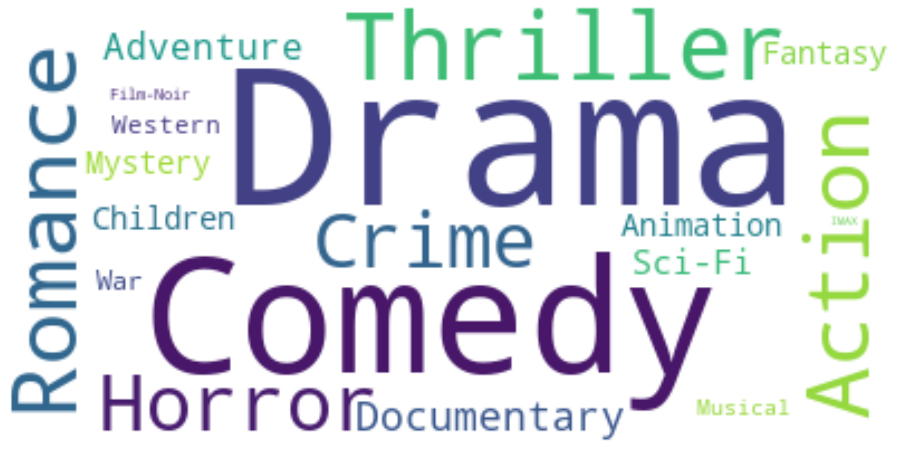

In [23]:
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


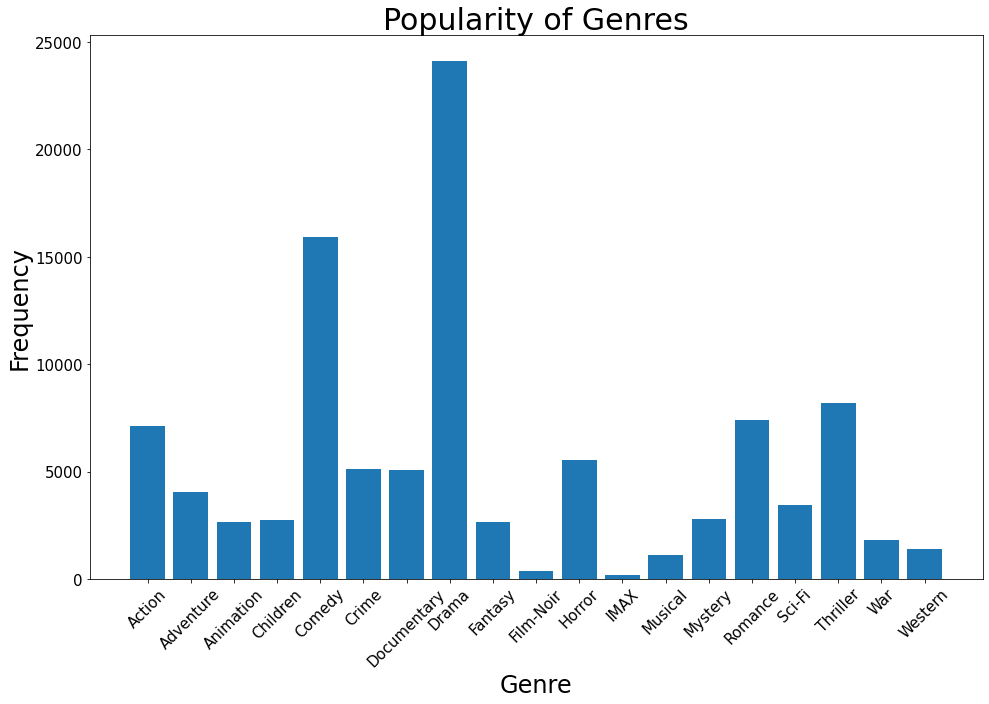

In [24]:
plt.figure(figsize=(16, 10))
plt.bar(genres, list(genre_freqs_dict.values()))
plt.title("Popularity of Genres", fontsize=30)
plt.xlabel("Genre", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.xticks(genres, genres, rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [25]:
genre_data = [
    movies_and_ratings_df.loc[movies_and_ratings_df[genre] == 1, "mean_rating"]
    for genre in genres
]
genre_data


[5        3.844211
 8        3.007530
 9        3.431633
 14       2.730977
 19       2.894483
            ...   
 50030    2.000000
 50045    4.000000
 50048    2.000000
 50051    3.000000
 50061    3.250000
 Name: mean_rating, Length: 6556, dtype: float64,
 0        3.886649
 1        3.246583
 7        3.122482
 9        3.431633
 12       3.339652
            ...   
 50018    2.000000
 50025    4.500000
 50030    2.000000
 50048    2.000000
 50060    2.000000
 Name: mean_rating, Length: 3731, dtype: float64,
 0        3.886649
 12       3.339652
 47       2.963168
 236      3.096537
 241      2.357143
            ...   
 50018    2.000000
 50025    4.500000
 50026    4.500000
 50027    3.500000
 50042    2.000000
 Name: mean_rating, Length: 2638, dtype: float64,
 0        3.886649
 1        3.246583
 7        3.122482
 12       3.339652
 26       3.425107
            ...   
 49924    3.500000
 49936    3.250000
 49955    2.500000
 49967    1.000000
 49996    2.000000
 Name: mean_ra

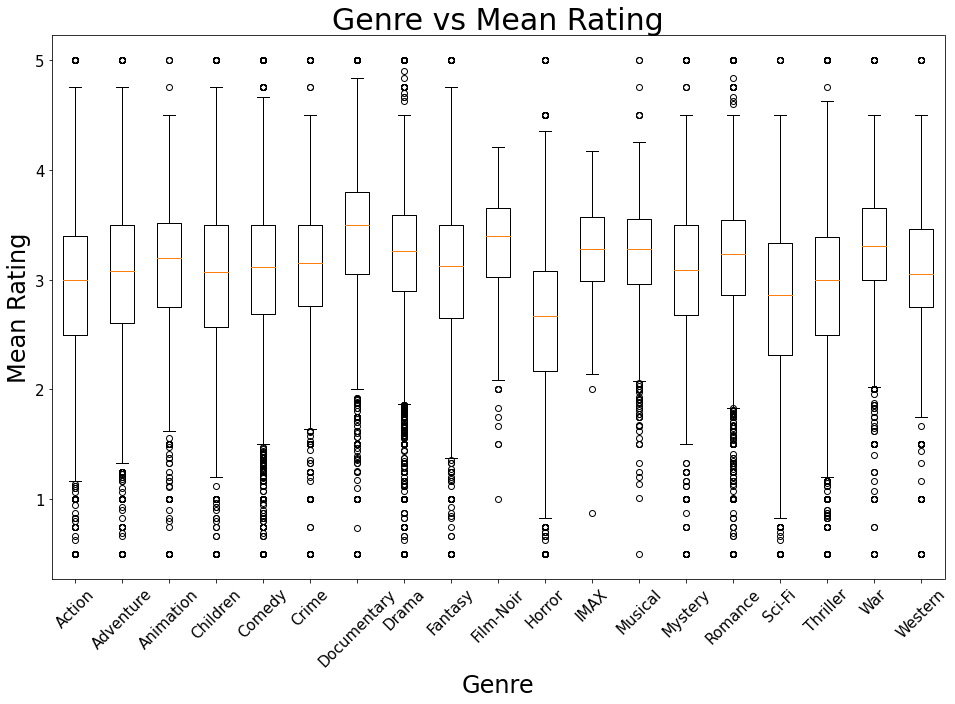

In [26]:
plt.figure(figsize=(16, 10))
plt.boxplot(genre_data, labels=genres)
plt.title("Genre vs Mean Rating", fontsize=30)
plt.xlabel("Genre", fontsize=24)
plt.ylabel("Mean Rating", fontsize=24)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()


### Relationship between Decade and Mean Rating of a Movie


In [27]:
decades_df = movies_and_ratings_df.groupby((movies_and_ratings_df["year"] // 10) * 10)


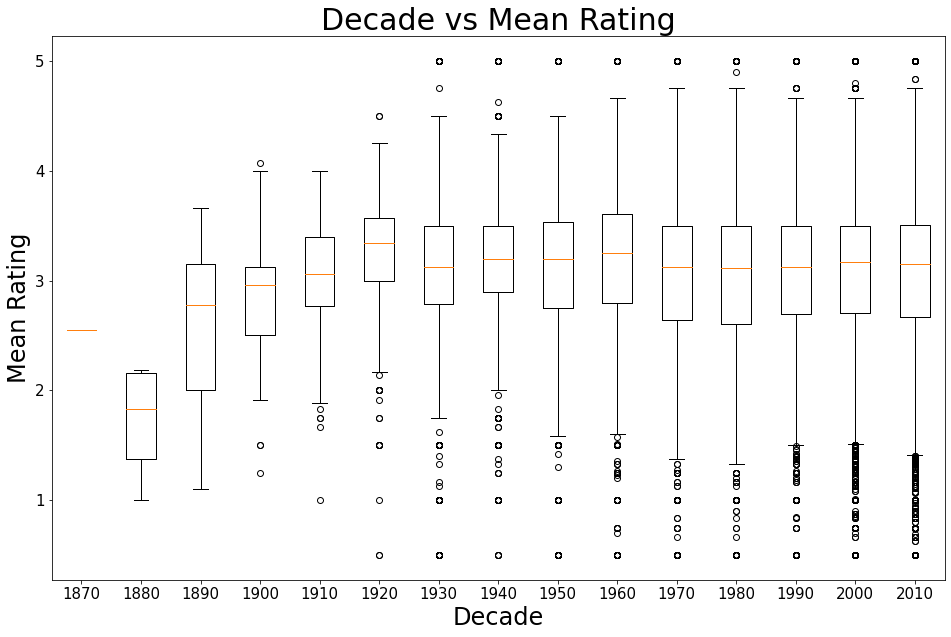

In [28]:
plt.figure(figsize=(16, 10))
plt.boxplot(
    [group["mean_rating"] for name, group in decades_df],
    labels=[name for name, group in decades_df],
)
plt.title("Decade vs Mean Rating", fontsize=30)
plt.xlabel("Decade", fontsize=24)
plt.ylabel("Mean Rating", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


Conclusion:

1. There are no noticeable changes in the mean ratings over the years.
2. The only significant observation from the two graphs is that the rating distribution has become more spread out, which could be due to a greater number of ratings or increased data availability.
3. Removing ratings for movies that are more than a century old may enhance the model's effectiveness.


### Relationship between Tag and Mean Rating of a Movie


This can be analyzed through the following steps:

1. Start by analyzing the frequency of movie tags.
2. Identify the top 5 or top 10 most frequently occurring tags and determine the corresponding top 5 most frequent ratings.
3. Determine the most frequent tags for each rating at 0.5 intervals.


In [29]:
tag_freq = dict(ratings_and_tags_df["tag"].value_counts().nlargest(10))
tag_freq


{'sci-fi': 8616,
 'atmospheric': 6205,
 'action': 5628,
 'comedy': 5239,
 'surreal': 5080,
 'twist ending': 4687,
 'funny': 4642,
 'visually appealing': 4188,
 'based on a book': 4169,
 'dystopia': 3977}

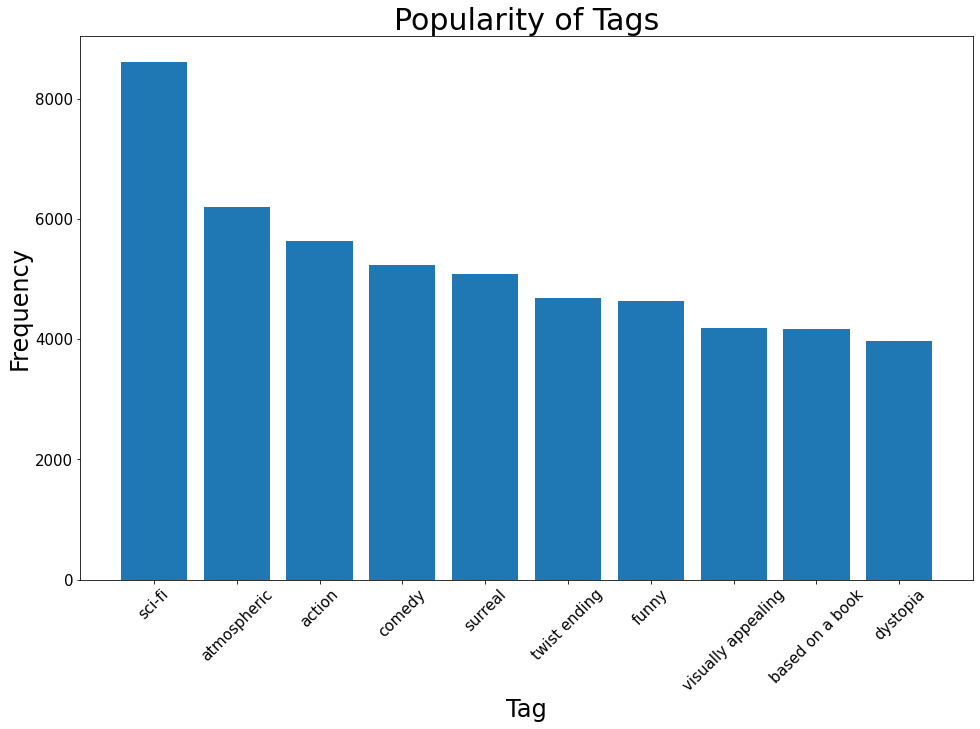

In [30]:
plt.figure(figsize=(16, 10))
plt.bar(tag_freq.keys(), tag_freq.values())
plt.title("Popularity of Tags", fontsize=30)
plt.xlabel("Tag", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [31]:
# Tagwise rating frequency
top_tags = tag_freq.keys()

print("Top 10 most frequent tags:", top_tags)

tag_rating_freq_df = ratings_and_tags_df[ratings_and_tags_df["tag"].isin(top_tags)]
tag_rating_freq_df = (
    tag_rating_freq_df.groupby(["tag", "rating"]).size().reset_index(name="count")
)
tag_rating_freq_df = tag_rating_freq_df.sort_values(
    ["tag", "count"], ascending=[True, False]
).reset_index(drop=True)

print("Top 10 most frequent tags and their ratings:")
tag_rating_freq_df


Top 10 most frequent tags: dict_keys(['sci-fi', 'atmospheric', 'action', 'comedy', 'surreal', 'twist ending', 'funny', 'visually appealing', 'based on a book', 'dystopia'])
Top 10 most frequent tags and their ratings:


,tag,rating,count
0,action,4.0,1346
1,action,5.0,1173
2,action,3.5,953
3,action,4.5,931
4,action,3.0,618
...,...,...,...
95,visually appealing,2.5,117
96,visually appealing,2.0,75
97,visually appealing,1.5,28
98,visually appealing,1.0,14


In [32]:
# Ratingwise tag frequency
rating_freq = ratings_and_tags_df["rating"].value_counts().head(5)
top_ratings = rating_freq.index.tolist()

print("Top 5 most frequent ratings:", top_ratings)

# Finding the top 10 most frequent tags for each of the top 5 ratings
# First filter the DataFrame to only include the top 5 ratings
rating_tag_freq_df = ratings_and_tags_df[
    ratings_and_tags_df["rating"].isin(top_ratings)
]
# Group the DataFrame by unique (rating, tag) combinations and count the number of occurrences
rating_tag_freq_df = (
    rating_tag_freq_df.groupby(["rating", "tag"])["tag"]
    .size()
    .reset_index(name="count")
)

# Create a new DataFrame that contains the top 10 most frequent tags for each rating
result_df = pd.concat(
    [
        rating_tag_freq_df.query("rating == @rating")
        .sort_values(by="count", ascending=False)
        .head(10)
        for rating in top_ratings
    ],
    ignore_index=True,
)

print("Top 10 most frequent ratings and their tags:")
result_df


Top 5 most frequent ratings: [4.0, 5.0, 4.5, 3.5, 3.0]
Top 10 most frequent ratings and their tags:


,rating,tag,count
0,4.0,sci-fi,2092
1,4.0,atmospheric,1506
2,4.0,action,1346
3,4.0,comedy,1284
4,4.0,funny,1283
5,4.0,twist ending,1158
6,4.0,surreal,1114
7,4.0,based on a book,1003
8,4.0,visually appealing,997
9,4.0,dystopia,970


Conclusion:

1. It is evident from the above analysis that movie tags with high frequency are more likely to have higher ratings.
2. Conversely, movie tags with lower ratings are less frequent in the dataset.
3. This suggests that the primary objective should be to recommend movies with higher ratings using the recommender system.
4. Additionally, tag suggestions can be provided to users based on the above analysis to enhance the data.


### Relationship between Tag + Genre and Ratings of a Movie


This can be analyzed through the following steps:

1. The initial step is to examine the relationship between genre and tag, specifically to determine if a tag has a closer association with a particular genre.
2. Visualize how the combinations of different genres and tags contribute to ratings. Only the top 5 most frequent ratings will be considered for this purpose.


In [33]:
# Genre Tag analysis
# Select top 10 Genres only
top_genres = genre_freqs.nlargest(10).index.tolist()

genre_tag_df = pd.concat(
    [
        tags_and_movies_df[tags_and_movies_df[genre] == 1]
        .groupby(["tag"])
        .size()
        .nlargest(10)
        .reset_index(name="count")
        .assign(genre=genre)
        for genre in top_genres
    ],
    axis=0,
    ignore_index=True,
)

genre_tag_df = genre_tag_df[["genre", "tag", "count"]]
genre_tag_df.sort_values("count", ascending=False)


,genre,tag,count
90,Sci-Fi,sci-fi,9243
40,Action,sci-fi,6148
41,Action,action,5560
10,Comedy,comedy,5465
80,Adventure,sci-fi,4379
...,...,...,...
75,Documentary,history,196
76,Documentary,BD-R,191
77,Documentary,movie business,186
78,Documentary,musicians,186


The preceding outcomes indicate an overlap between tags and genres. For example, thrillers are linked with tags like "atmospheric" and "suspense".


Now, the above analysis needs to be conducted for each of the most frequent ratings. This analysis will reveal whether a single genre with a specific tag will actually result in that genre.


In [34]:
# frequent ratings are calculated in rating_freq
results = []

for rating in top_ratings:
    for genre in genres:
        subset = combined_df.loc[
            (combined_df[genre] == 1) & (combined_df["rating"] == rating),
            ["rating", genre, "tag"],
        ]
        subset = (
            subset.groupby([genre, "tag"])
            .size()
            .reset_index(name="count")
            .sort_values(by="count", ascending=False)
            .head(10)
        )
        subset["rating"] = rating
        subset["genre"] = genre
        results.append(subset)

rating_genre_tag_df = pd.concat(results, ignore_index=True)
rating_genre_tag_df


,Action,tag,count,rating,genre,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,sci-fi,1369,4.0,Action,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,action,1199,4.0,Action,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,superhero,582,4.0,Action,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,dystopia,560,4.0,Action,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,visually appealing,404,4.0,Action,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,NaN,spaghetti western,11,3.0,Western,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
946,NaN,violence,10,3.0,Western,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
947,NaN,sci-fi,10,3.0,Western,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
948,NaN,John Wayne,10,3.0,Western,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


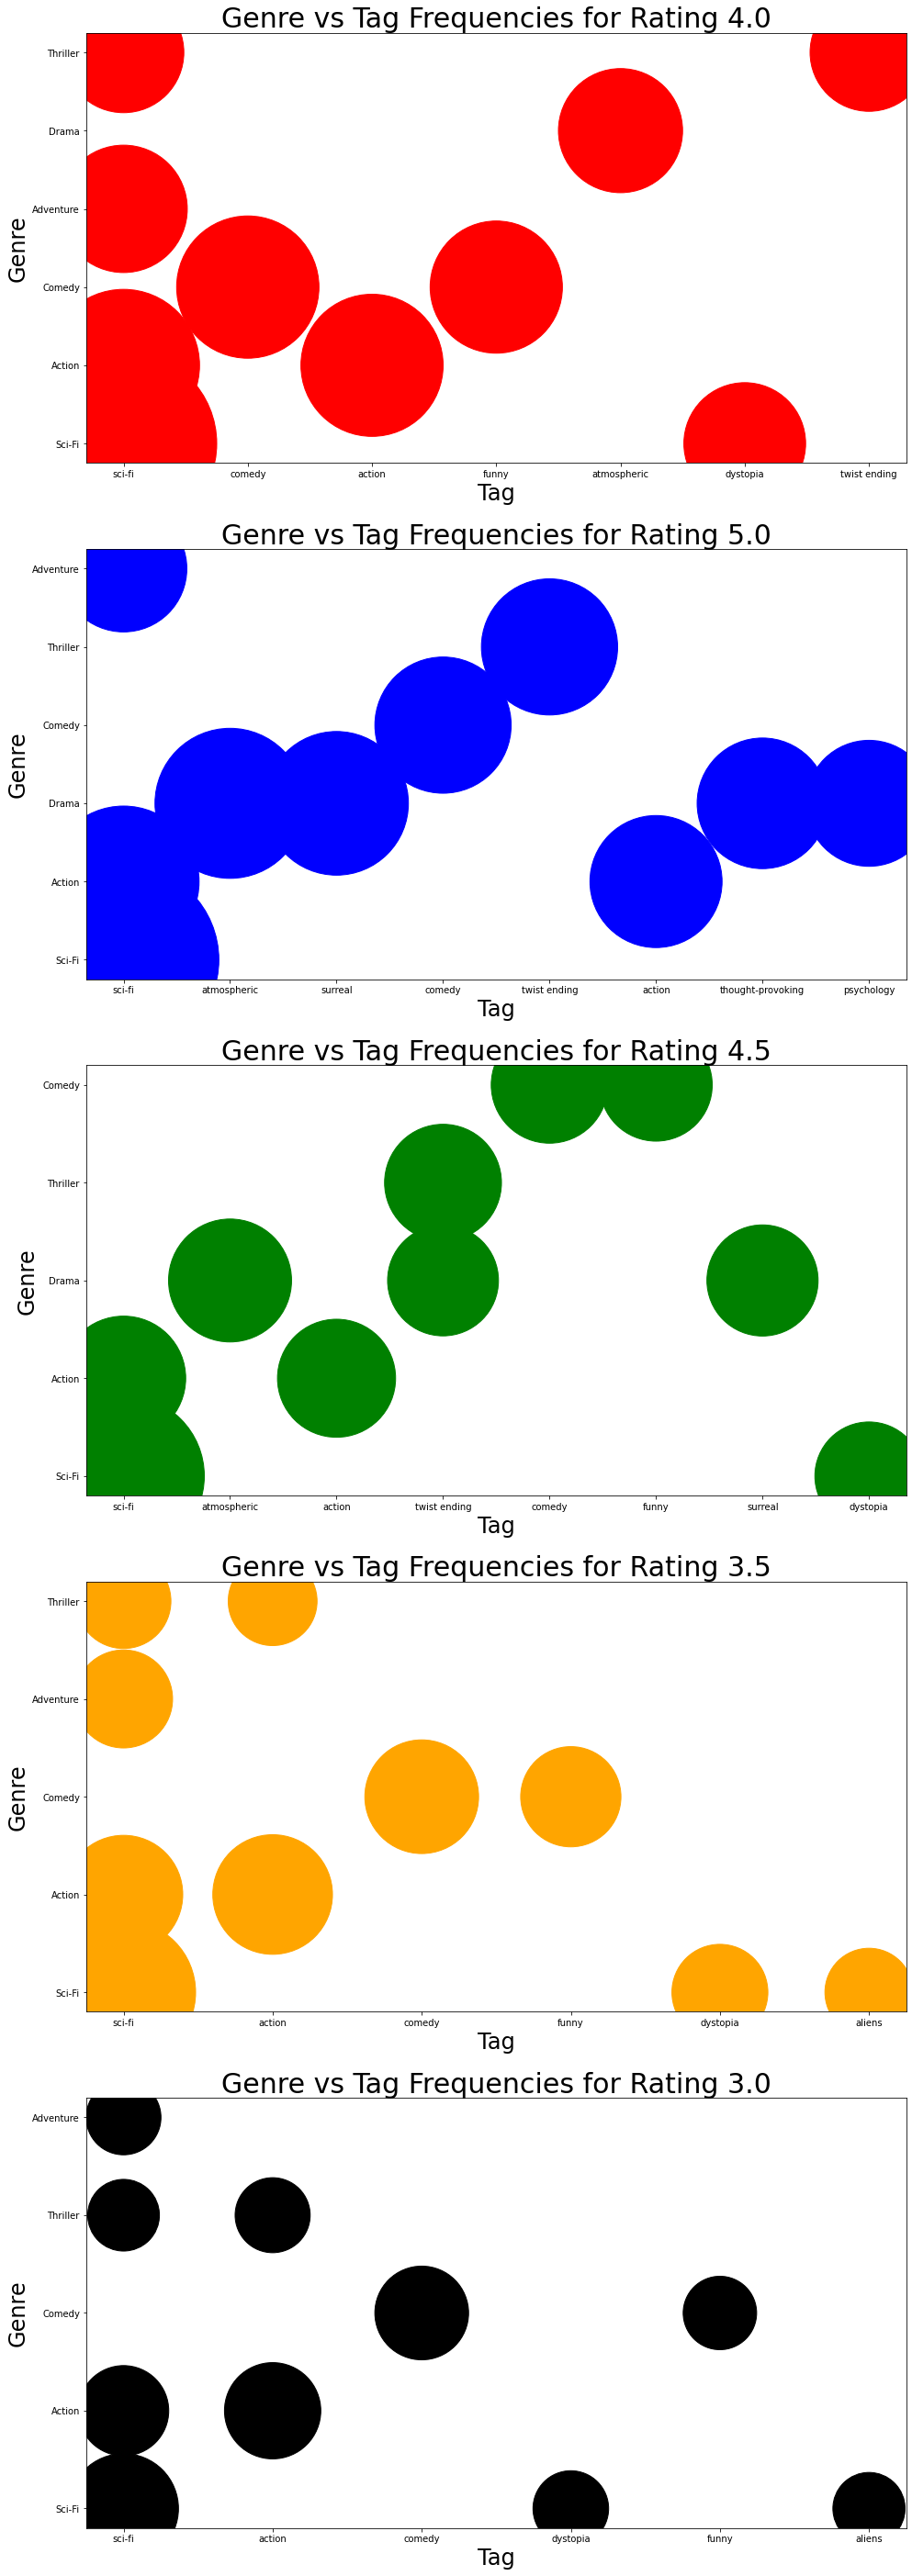

In [35]:
# Visualization of the relationship
unique_ratings = rating_genre_tag_df["rating"].unique()
fig, ax = plt.subplots(len(unique_ratings), 1, figsize=(16, 50))
colors = ["red", "blue", "green", "orange", "black"]

for i, rating in enumerate(unique_ratings):
    subset = (
        rating_genre_tag_df[rating_genre_tag_df["rating"] == rating]
        .sort_values(ascending=False, by="count", ignore_index=True)
        .head(10)
    )
    x = subset["tag"]
    y = subset["genre"]
    s = subset["count"] * 20
    ax[i].scatter(x, y, s, c=colors[i])
    ax[i].set_title(f"Genre vs Tag Frequencies for Rating {rating}", fontsize=30)
    ax[i].set_xlabel("Tag", fontsize=24)
    ax[i].set_ylabel("Genre", fontsize=24)

plt.show()


Conclusion:

1. The above analysis demonstrates how the assigned tag and genre can provide insight into the expected ratings of a movie.
2. Movies with higher ratings are more likely to be recommended to customers.


Based on user analysis, the ratings are divided into two segments: high ratings (3-5) and low ratings (0-2.5). For each individual user, their rating can be determined based on which segment it falls into.


### Recommendation system

Which recommender system to use?

1. If the collaborative filtering recommender system is used, there may be a lack of data for a particular user, which can limit the recommendations. Additionally, there may not be sufficient data available to measure the similarity between users.
2. A content-based recommendation system is a suitable option in this case, as there are parameters such as tags, genres, and release years that can affect the ratings of movies.


## Part 3: Collaborative Filtering Recommendation System


Here are the steps that will be followed to build the recommendation system:

1. A combined dataset consisting of movies, users, ratings, and tags will be utilized, which will then be split into test and train datasets in an 80-20 ratio.
2. Data will be cleaned based on analysis, specifically by removing infrequent tags and genres from the dataset.
3. TF-IDF will be used, which combines genres and tags, and count vectorization will be performed.
4. A model will be built using k-nearest neighbors along with cosine similarity.


In [36]:
combined_df.head()


,userId,movieId,rating,tag,title,year,Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,14,110,4.5,epic,Braveheart (1995),1995,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,14,110,4.5,Medieval,Braveheart (1995),1995,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,815,110,2.5,overrated,Braveheart (1995),1995,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2577,110,4.5,Oscar (Best Picture),Braveheart (1995),1995,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3086,110,5.0,epic,Braveheart (1995),1995,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
tag_counts = combined_df["tag"].value_counts()
tag_counts.tail(200)


2rate                 1
howard hawks          1
mixed footage         1
the devil             1
miserable             1
                     ..
Grace Gummer          1
We                    1
Shani Wallis          1
Michael Earl Davis    1
AFI #46               1
Name: tag, Length: 200, dtype: int64

In [38]:
tag_threshold = 120
combined_df = combined_df[combined_df["tag"].map(tag_counts) >= tag_threshold]


In [39]:
genre_counts = combined_df[genres].sum().sort_values(ascending=False)
genre_counts


Drama          263149
Thriller       167082
Action         158669
Comedy         140267
Sci-Fi         135254
Adventure      115085
Crime           94765
Romance         84504
Fantasy         65120
Mystery         63787
Horror          49517
IMAX            40481
Animation       35156
Children        27420
War             23999
Musical         13367
Film-Noir        7823
Western          6659
Documentary      6404
dtype: int64

In [40]:
genre_threshold = 10000
insig_genre = genre_counts[genre_counts < genre_threshold].index
insig_genre


Index(['Film-Noir', 'Western', 'Documentary'], dtype='object')

In [41]:
def has_only_insignificant_genres(genres, insig_genres):
    return all(genre in insig_genres for genre in genres.split("|"))


# Remove entries with only insignificant genres
# combined_df = combined_df[~combined_df['genres'].apply(lambda x: has_only_insignificant_genres(x, insig_genre))]


In [42]:
# Create feature vectors for each movie using tags, genres, and year
vectorizer = TfidfVectorizer(
    strip_accents="unicode",
    lowercase=True,
    analyzer="word",
    ngram_range=(1, 2),
    stop_words="english",
)
X = vectorizer.fit_transform(
    combined_df["tag"]
    + " "
    + combined_df[genres].astype(str).apply(" ".join, axis=1)
    + " "
    + combined_df["year"].astype("str")
)
y = combined_df["rating"]

# Reset the index of the DataFrame
combined_df = combined_df.reset_index(drop=True)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the number of neighbors to use
k = 5

knn = KNeighborsRegressor(n_neighbors=k, metric="cosine")
knn.fit(X_train, y_train)


KNeighborsRegressor(metric='cosine')

In [43]:
# Predict ratings for each movie in the test dataset
y_pred = knn.predict(X_test)

# Calculate the RMSE score
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate the precision, recall, and F1 score for a rating threshold of 3.5
threshold = 3.5
y_pred_binary = (y_pred >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1_score = f1_score(y_test_binary, y_pred_binary)

print("RMSE:", rmse)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


RMSE: 0.9878422555361871
Precision: 0.8302200034829047
Recall: 0.861433011299299
F1 Score: 0.8455385488533778
